<a href="https://colab.research.google.com/github/ShihanZENG/Awesome-DSDO/blob/main/Big_data_analytics/Data_cleaning_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data checking & Data cleaning

Upload data into Google Cloud

In [13]:
from google.colab import files
uploaded = files.upload()

Load the data into dataframe using Pandas

In [55]:
import pandas as pd
df = pd.read_csv('MoviesOnStreamingPlatform.csv')
df.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,1,Inception,2010,13+,8.8,87%,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


Here we found the data look weird. Then we follow the investigation. We check the shape of the dataframe and the column list.

In [56]:
df.shape

(16744, 15)

Now we found the problem. This csv file is with delimiter and cannot be read properly if we do not define the delimiter. So, we need to go back to the first step and read the data again, but this time we define the delimiter (in this case the delimiter is ";").

Cool! Now the data looks good. We need further check to see how we should clean the data. First we check the data types and understand whether they are all in right format.

In [57]:
df.dtypes

,0
ID,int64
Title,object
Year,int64
Age,object
IMDb,float64
Rotten Tomatoes,object
Netflix,int64
Hulu,int64
Prime Video,int64
Disney+,int64


By checking the data types, we found that there are lots of air quality index columns, such as CO(GT), are all object format and not numeric. By looking at the data more carefully, we found that the decimal is not in the right format. They use "," instead of "." so it could be recognised as number. So the easy way is to replace "," with "." And then change the data type to "float". Here we use two methods to help us:



```
df.replace() # we need to make sure the column is string, so we use df[col].str.replace()
df.astype(float) # we use .astype to set up the right data format for the column
```

To do it more efficiently (instead of doing column by column manually), we can use for loop by checking all these columns and replace for all. Here we use the following syntax to help us find out all object_columns:



```
df.dtypes['df.dtypes == 'object'].index.values.tolist()
# so first we find out all columns which are in object format,
# and then we return the index value which is the column name,
# and convert the column names into list.

# if you also want to find out the numeric columns, use similar method
numeric_columns=df.dtypes[df.dtypes == "float64"].index.values.tolist()
```


In [58]:
object_columns = df.dtypes[df.dtypes == "object"].index.values.tolist()
object_columns

['Title',
 'Age',
 'Rotten Tomatoes',
 'Directors',
 'Genres',
 'Country',
 'Language']

We listed all object columns, but the list also includes "Date" and "Time" columns. So, we will use object_columns[2:] to exclude the first two columns in the list.



In [59]:
object_columns[2:]

['Rotten Tomatoes', 'Directors', 'Genres', 'Country', 'Language']

The following codes show how we loop each problematic index column and replace "," with "." and change the format to float.

In [60]:
df_cleaned = df.copy()

In [61]:
# Clean numerical columns
df_cleaned['Rotten Tomatoes'] = df['Rotten Tomatoes'].str.rstrip('%').astype(float)
df_cleaned['Age'].str.rstrip('+')
df_cleaned.loc[df['Age'].str.lower() == 'all', 'Age'] = 100
df_cleaned['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df_cleaned['Genres'] = df['Genres'].str.split(',')
df_cleaned_exploded = df.explode('Genres')
df_cleaned_exploded['Genres'].value_counts()

,count
Genres,
Drama,1341
Documentary,1229
Comedy,1040
"Comedy,Drama",446
Horror,436
...,...
"Drama,Crime,Mystery",1
"Crime,Drama,Thriller,Western",1
"Documentary,Music,Musical",1


In [64]:
df_cleaned_exploded.groupby('Genres')['IMDb'].mean()

,IMDb
Genres,
Action,4.865734
"Action,Adventure",4.972340
"Action,Adventure,Biography",6.200000
"Action,Adventure,Biography,Drama,History",7.633333
"Action,Adventure,Biography,Drama,History,Romance,War",2.000000
...,...
Western,5.759130
"Western,Comedy",4.050000
"Western,Horror",3.900000


In [67]:
# 1. 拆分为list
df_cleaned_exploded['Genres'] = df_cleaned_exploded['Genres'].str.split(',\s*')

# 2. explode拆成多行
df_cleaned_exploded = df_cleaned_exploded.explode('Genres')

# 3. 去空格
df_cleaned_exploded['Genres'] = df_cleaned_exploded['Genres'].str.strip()

# 4. 分组求平均+数量
result = (
    df_cleaned_exploded
    .groupby('Genres')
    .agg(
        average_IMDb=('IMDb', 'mean'),
        movie_count=('IMDb', 'count')
    )
    .sort_values('average_IMDb', ascending=False)
    .head(10)
)
print(result)


             average_IMDb  movie_count
Genres                                
News             7.109901          101
Documentary      6.942612         2389
Biography        6.808674          807
History          6.731746          693
Music            6.600000          647
Short            6.441228          342
Sport            6.417857          392
Film-Noir        6.332911           79
Animation        6.252129          681
War              6.250380          526


In [69]:
df_cleaned_exploded.shape

(39373, 15)

In [68]:
result = (
    df_cleaned_exploded
    .groupby('Genres')
    .agg(
        average_IMDb=('IMDb', 'mean'),
        movie_count=('IMDb', 'count')
    )
    .sort_values('average_IMDb', ascending=False)
    .head(10)
)
print(result)

             average_IMDb  movie_count
Genres                                
News             7.109901          101
Documentary      6.942612         2389
Biography        6.808674          807
History          6.731746          693
Music            6.600000          647
Short            6.441228          342
Sport            6.417857          392
Film-Noir        6.332911           79
Animation        6.252129          681
War              6.250380          526


In [70]:
df.Genres.unique()

array(['Action,Adventure,Sci-Fi,Thriller', 'Action,Sci-Fi',
       'Action,Adventure,Sci-Fi', ..., 'Comedy,Family,Fantasy,Mystery',
       'Family,Drama,Western', 'Comedy,Family,Adventure,Fantasy,Sci-Fi'],
      dtype=object)

In [71]:
object_columns[2:]

['Rotten Tomatoes', 'Directors', 'Genres', 'Country', 'Language']

In [ ]:
object_columns = df.dtypes[df.dtypes == "object"].index.values.tolist()
object_columns

['Title', 'Directors', 'Genres', 'Country', 'Language']

In [45]:
for col in object_columns[2:]:
  df[col] = df[col].str.replace(',','.').astype(float)

df.head()

ValueError: could not convert string to float: 'Action.Adventure.Sci-Fi.Thriller'

Double checking the data types, all data formats are correct.

In [72]:
df.dtypes

,0
ID,int64
Title,object
Year,int64
Age,object
IMDb,float64
Rotten Tomatoes,object
Netflix,int64
Hulu,int64
Prime Video,int64
Disney+,int64


We further check the missing values. It is very common to have missing values in the real-world data. But we cannot just drop easily. We need to understand why there are missing values and how to deal with them.

In [ ]:
df_cleaned.dropna(subset=['Age', 'Genres'], inplace=True)

In [48]:
df.isnull().sum()

,0
ID,0
Title,0
Year,0
Age,15901
IMDb,571
Rotten Tomatoes,11586
Netflix,0
Hulu,0
Prime Video,0
Disney+,0


By checking this list of missing value counts, we found that there are two columns are complete empty and the column names doesn't make sense at all. Thus, before we use dropna() we need to remove these two columns first. If not, when we use dropna() we will lose all data. And then come back and check other columns. We have 9471 instances, and these columns all have 114 missing values. We can consider fill the missing value, for example using mean/median, but given it is not large number compared to the overall size, we will just drop all missing value.

In [77]:
df_cleaned_exploded.isnull().sum()

,0
ID,0
Title,0
Year,0
Age,20127
IMDb,896
Rotten Tomatoes,25584
Netflix,0
Hulu,0
Prime Video,0
Disney+,0


In [76]:
df_cleaned_exploded_dropna = df_cleaned_exploded.drop(['IMDb','Genres'], axis = 1)
df_cleaned_exploded_dropna.drop(columns=['Age', 'Rotten Tomatoes'], inplace=True)
df_cleaned_exploded_dropna.dropna(inplace=True)
df_cleaned_exploded_dropna
df_cleaned_exploded_dropna.head()

,ID,Title,Year,Netflix,Hulu,Prime Video,Disney+,Directors,Country,Language,Runtime
0,1,Inception,2010,1,0,0,0,Christopher Nolan,"United States,United Kingdom","English,Japanese,French",148.0
0,1,Inception,2010,1,0,0,0,Christopher Nolan,"United States,United Kingdom","English,Japanese,French",148.0
0,1,Inception,2010,1,0,0,0,Christopher Nolan,"United States,United Kingdom","English,Japanese,French",148.0
0,1,Inception,2010,1,0,0,0,Christopher Nolan,"United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,1,0,0,0,"Lana Wachowski,Lilly Wachowski",United States,English,136.0


In [78]:
df_cleaned_exploded_dropna.isnull().sum()

,0
ID,0
Title,0
Year,0
Netflix,0
Hulu,0
Prime Video,0
Disney+,0
Directors,0
Country,0
Language,0


In [82]:
df_cleaned_exploded_dropna.shape

(37132, 11)

# Exploratory Data Analysis (EDA)

1. Descriptive Statistics: We can analyse the data by computing descriptive statistics, providing a summary overview of the central tendency, dispersion, and shape of the dataset's distribution. This step helps identify initial patterns, potential outliers, and the general data structure.

In [84]:
df_cleaned_exploded_dropna.describe()

,ID,Year,Netflix,Hulu,Prime Video,Disney+,Runtime
count,37132.000000,37132.000000,37132.000000,37132.000000,37132.000000,37132.000000,37132.000000
mean,8265.748115,2001.411505,0.204487,0.060864,0.722530,0.054616,95.303189
std,4908.685489,21.786702,0.403331,0.239084,0.447756,0.227232,25.464837
min,1.000000,1902.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4186.000000,1997.000000,0.000000,0.000000,0.000000,0.000000,84.000000
50%,8072.000000,2011.000000,0.000000,0.000000,1.000000,0.000000,93.000000
75%,12505.000000,2016.000000,0.000000,0.000000,1.000000,0.000000,106.000000
max,16744.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,410.000000


Visualisation is a powerful tool for EDA. We can use it to check distribution, relationship, outliers and etc. The following examples will show different use of visualisation for exploring the data and feature engineering.

2. Distribution Analysis: By examining the distribution of key features, we understand the variability and skewness in different variables.

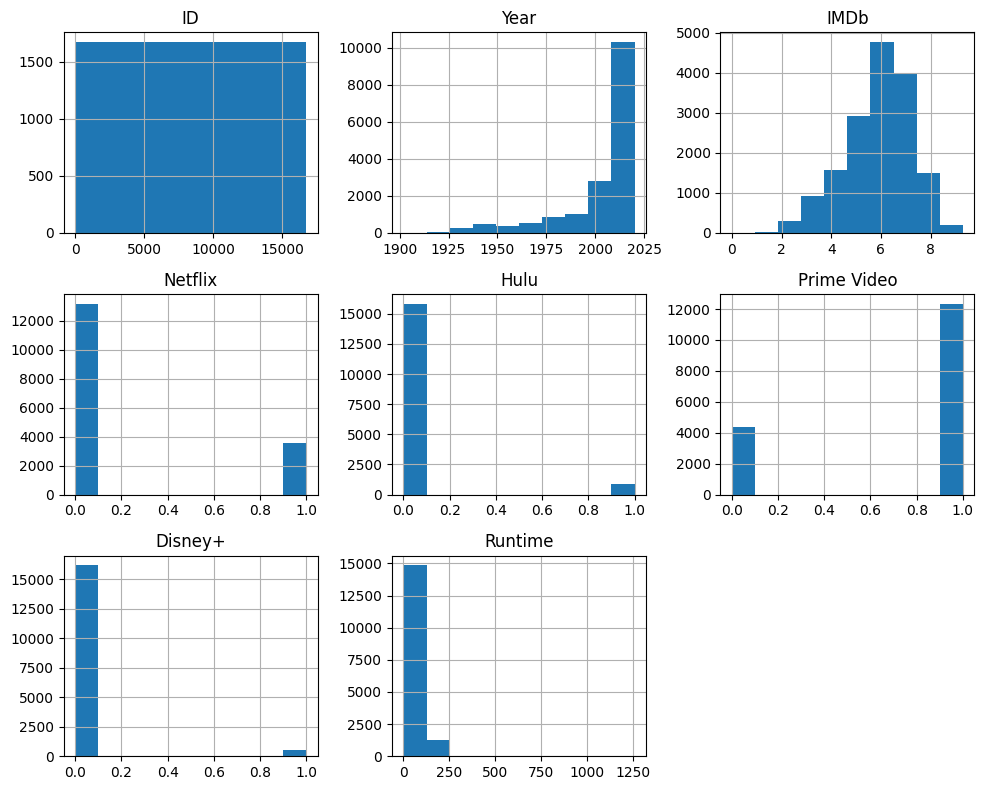

In [85]:
import matplotlib.pyplot as plt
# Create subplots for each column
df.hist(figsize=(10, 8))

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
sensor_col = df.columns[df.columns.str.startswith('PT08')].tolist()
air_col = ['T','AH','RH']
Ref_col = df.drop(columns = sensor_col+air_col+['Date']+['Time']).columns.tolist()

3. Time Series Analysis: Given the temporal nature of the dataset, we can explore trends over time. This involves aggregating data at various time intervals—daily, hourly.

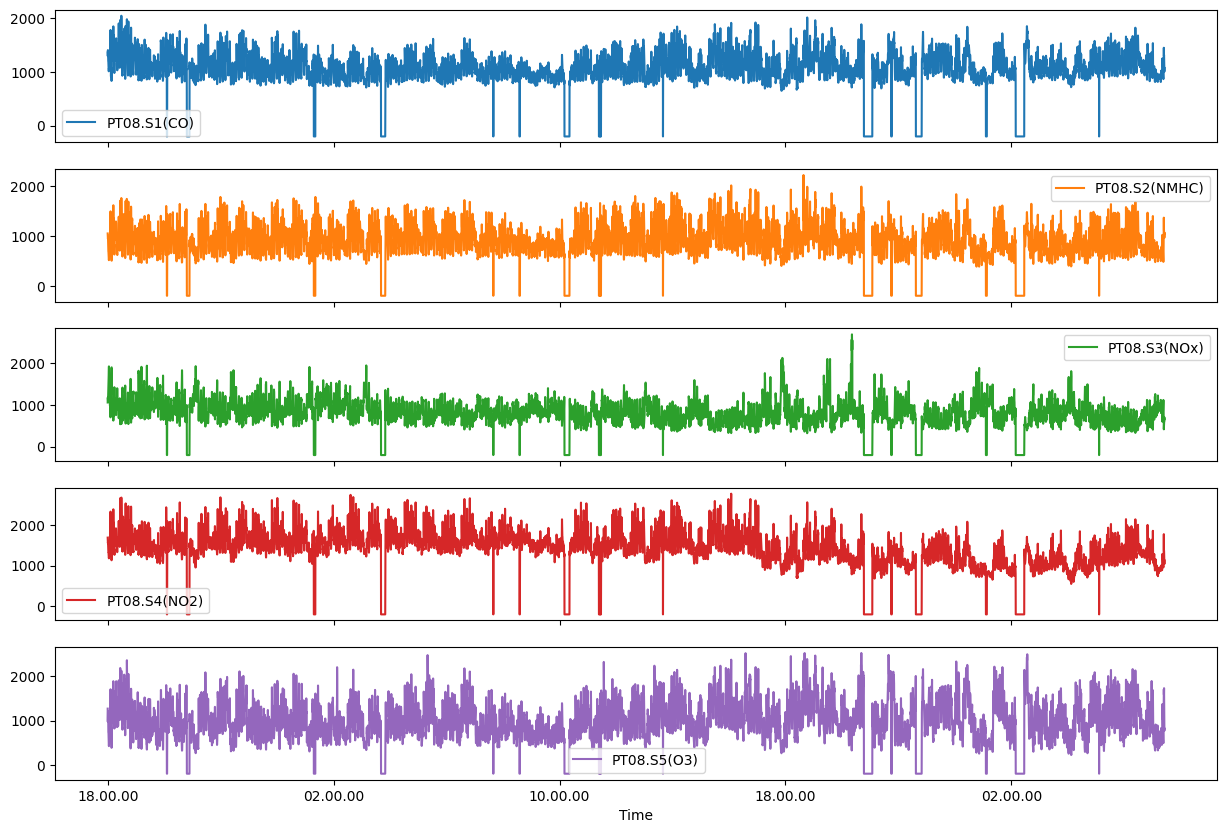

In [ ]:
col = sensor_col+['Date','Time']
axes = df[col].plot.line(x = 'Time',subplots=True, figsize=(15, 10))

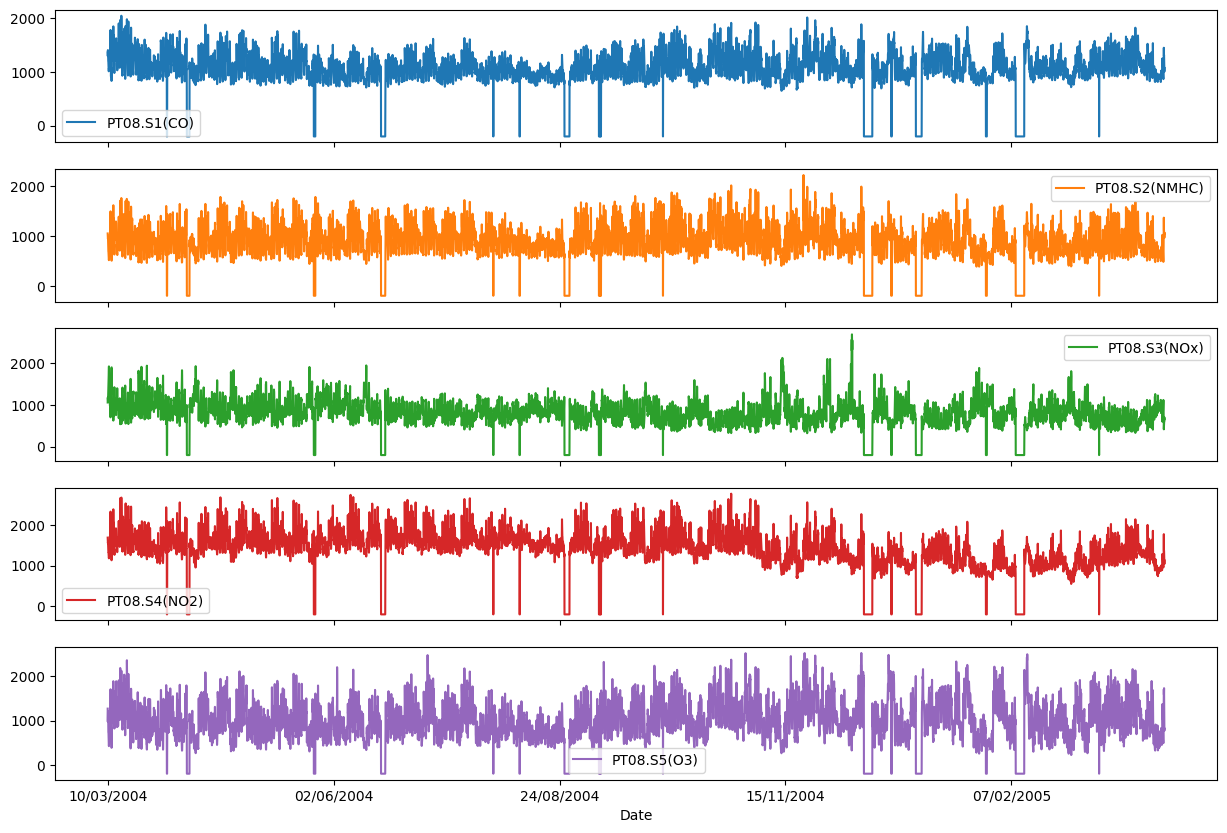

In [ ]:
axes = df[col].plot.line(x = 'Date',subplots=True, figsize=(15, 10))

4. Correlation Analysis: A correlation matrix enables exploring the relationships between different numerical features. This analysis can highlight potential dependencies and associations between attributes, aiding in feature selection and model development. We can also use pairplot to visualise the bivariate relationship.

In [95]:
numeric_columns=df_cleaned_exploded_dropna.dtypes[df_cleaned_exploded_dropna.dtypes == "float64"].index.values.tolist()

corr1 = df_cleaned_exploded_dropna[numeric_columns].corr()
corr1.style.background_gradient(cmap='coolwarm').format(precision=2)

,Runtime
Runtime,1.00


In [96]:
corr1 = df_cleaned_exploded_dropna[numeric_columns].corr()
corr1.style.background_gradient(cmap='coolwarm').format(precision=2)

,Runtime
Runtime,1.00


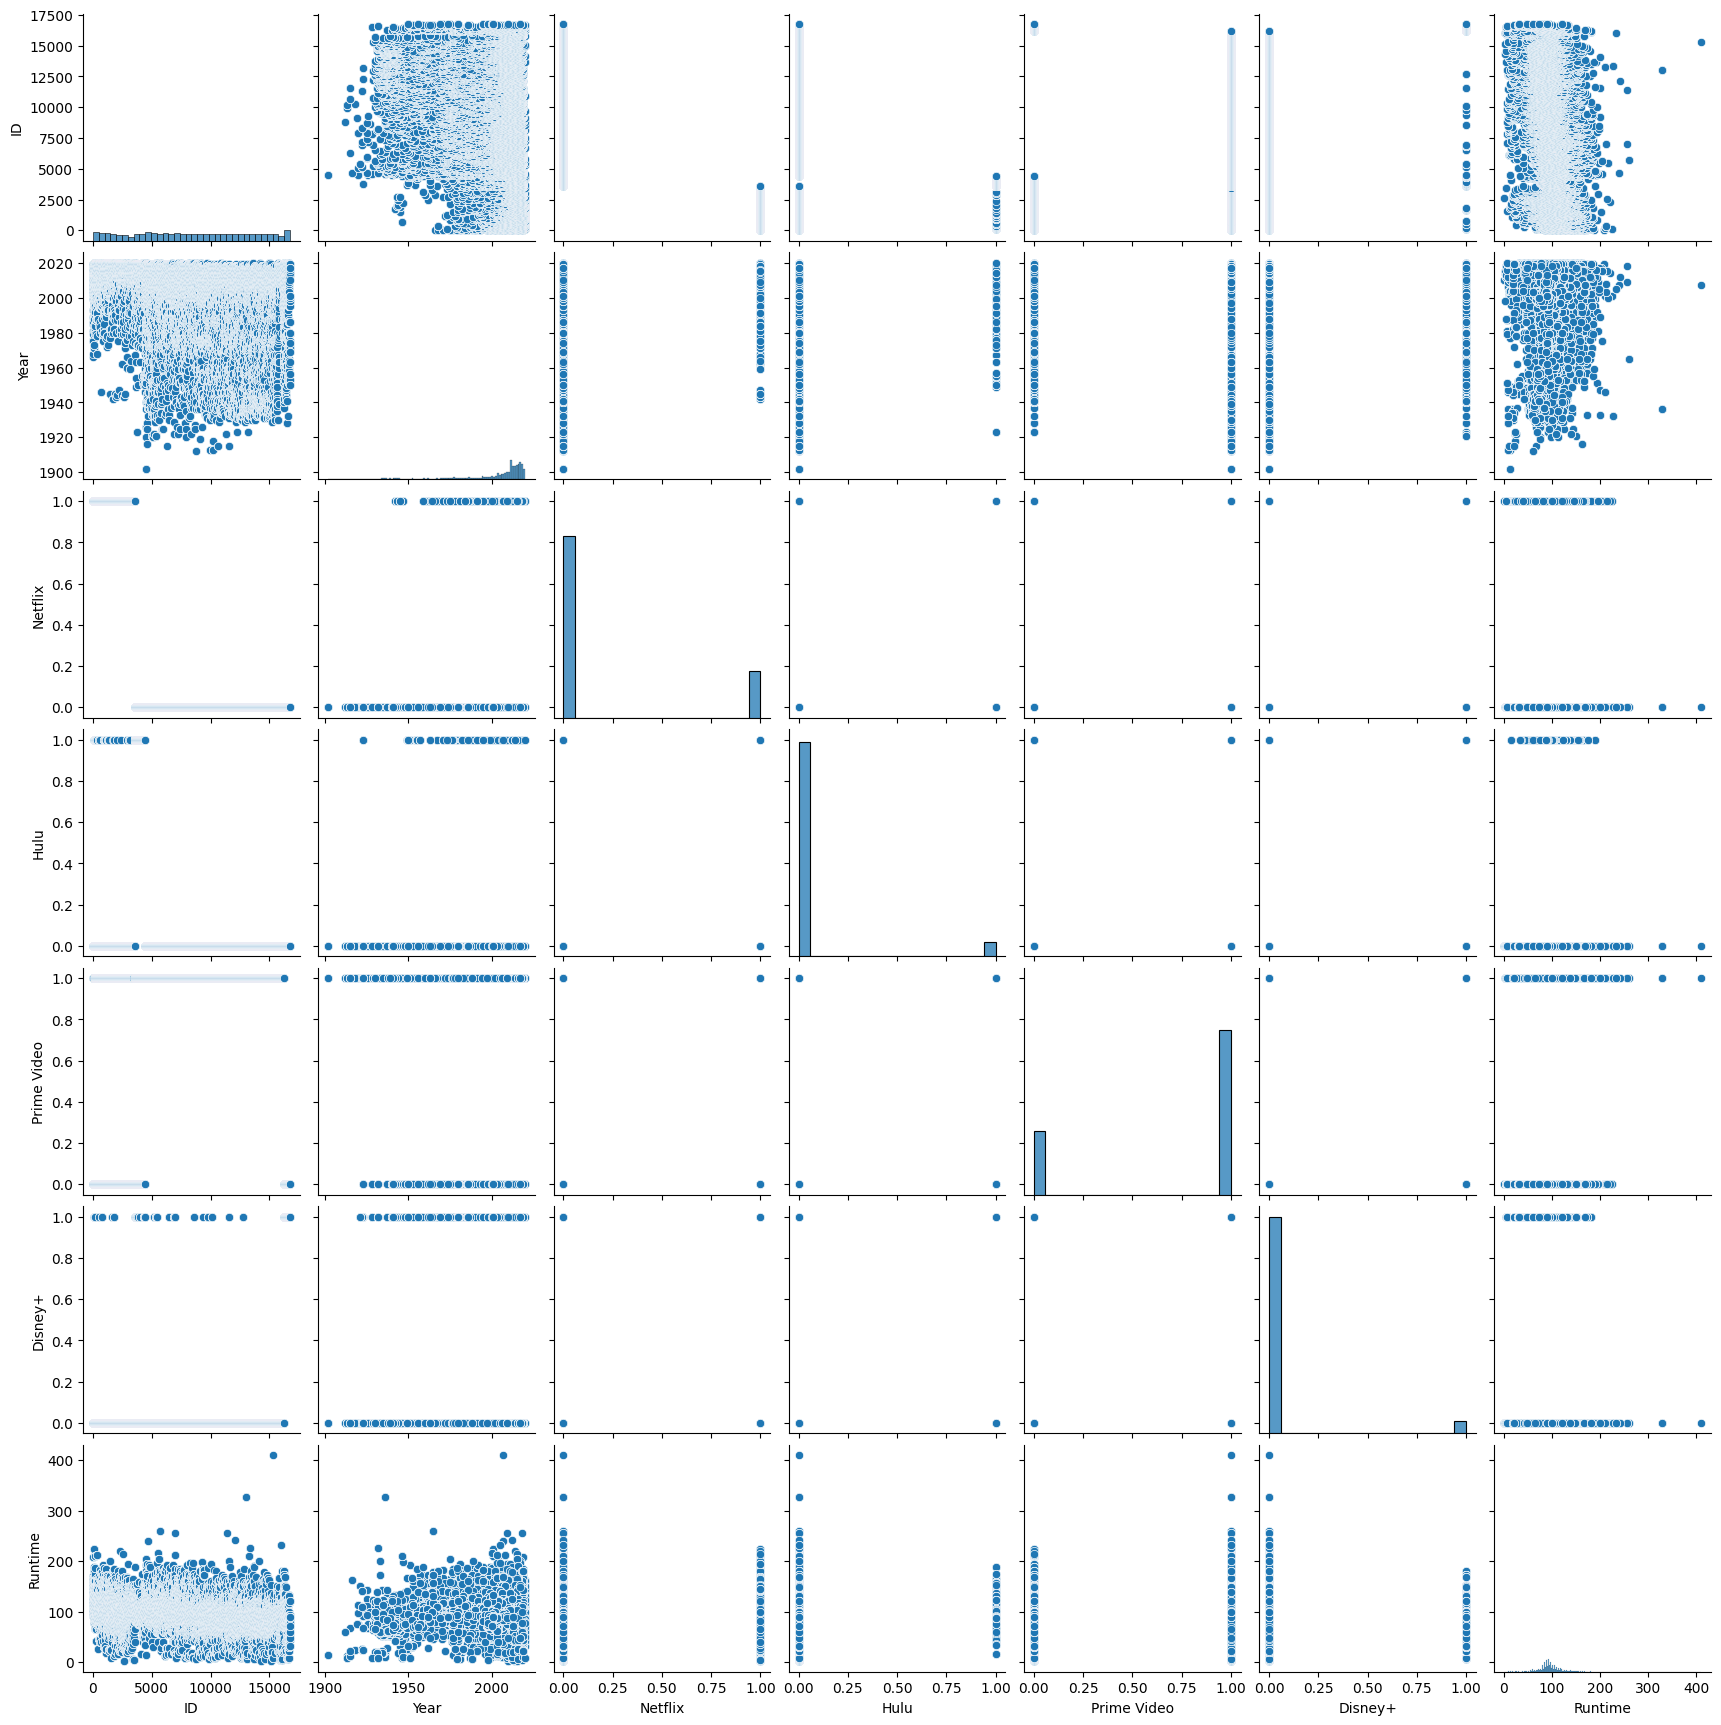

In [97]:
import seaborn as sns
sns.pairplot(df_cleaned_exploded_dropna)

In [98]:
import seaborn as sns
sns.pairplot(df[sensor_col])

NameError: name 'sensor_col' is not defined